In [ ]:
!pip install git+https://github.com/qubvel/efficientnet

In [ ]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from efficientnet.keras import EfficientNetB0 as ENetB0
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi


2.2.0


Using TensorFlow backend.


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!unzip "/content/gdrive/My Drive/Project/train.zip" -d "./"

In [ ]:
!unzip "/content/gdrive/My Drive/Project/test.zip" -d "./"

In [ ]:
trainDF = pd.read_csv("/content/gdrive/My Drive/Project/train.txt", sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv("/content/gdrive/My Drive/Project/test.txt", sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 

datagen = ImageDataGenerator(
            rescale=1./255,
            zca_whitening=True,
            rotation_range=5,
            zoom_range=[0.1, 0.5],
            height_shift_range=[0.1,0.3],
            brightness_range=[0.55,1.0],
            fill_mode='nearest',
            validation_split=0.25)

trainData = trainDF.shape[0] * 0.75
valData = trainDF.shape[0] * 0.25
# print(trainData, valData)

test_datagen = ImageDataGenerator(rescale=1./255)

BatchSize = 98

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/content/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/content/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:337: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


Found 27342 validated image filenames.
Found 9113 validated image filenames.


In [ ]:
def architecture(width, height, depth):

    model = ENetB0(weights='imagenet', include_top=False, input_shape=(height, width, depth))
    return model

model = architecture(width=200, height=100, depth=3)
print (model.summary())

16809984/16804768 [==============================] - 2s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 100, 200, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 50, 100, 32)  864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 50, 100, 32)  128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 50, 100, 32)  0           stem_bn[0][0]                    
___________________

In [ ]:
def ENetB0_FT(width, height, depth):

    conv_base = ENetB0(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


16809984/16804768 [==============================] - 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


279/279 [==============================] - 333s 1s/step - loss: 0.8072 - val_loss: 0.5606

Epoch 00001: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FT/ENetB0_FT_weights.01-0.56.h5


/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


Epoch 2/10
279/279 [==============================] - 330s 1s/step - loss: 0.6297 - val_loss: 0.4945

Epoch 00002: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FT/ENetB0_FT_weights.02-0.49.h5
Epoch 3/10
279/279 [==============================] - 317s 1s/step - loss: 0.5244 - val_loss: 0.5405

Epoch 00003: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FT/ENetB0_FT_weights.03-0.54.h5
Epoch 4/10
279/279 [==============================] - 317s 1s/step - loss: 0.4510 - val_loss: 0.4727

Epoch 00004: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FT/ENetB0_FT_weights.04-0.47.h5
Epoch 5/10
279/279 [==============================] - 317s 1s/step - loss: 0.4035 - val_loss: 0.3388

Epoch 00005: saving model to /content/gdrive/My Drive/Project/ENetB0/ENetB0_FT/ENetB0_FT_weights.05-0.34.h5
Epoch 6/10
279/279 [==============================] - 318s 1s/step - loss: 0.3664 - val_loss: 0.4162

Epoch 00006: saving model to /content/gdrive/My Drive/Proj

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


avg_train_loss: 0.4469614785004367
avg_val_loss: 0.43832474052906034
difference: 0.008636737971376374


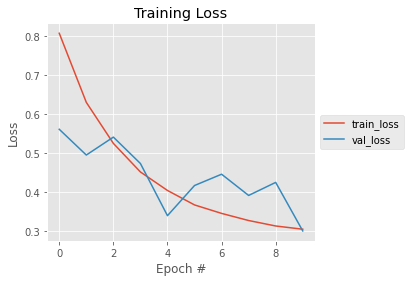

In [ ]:
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 10

model = ENetB0_FT(width=200, height=100, depth=3)

filepath =  "/content/gdrive/My Drive/Project/ENetB0/ENetB0_DA/ENetB0_DA_weights.08-0.81.h5"

model.load_weights(filepath)

conv_base = ENetB0(weights='imagenet', include_top=False, input_shape=(100, 200, 3))

conv_base.trainable = True
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block7a_expand_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1e-3), loss="mse")

filepath1 = "/content/gdrive/My Drive/Project/ENetB0/ENetB0_FT/ENetB0_FT_weights.{epoch:02d}-{val_loss:.2f}.h5"
checkpoint = ModelCheckpoint(filepath1, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=round(trainData/BatchSize),
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=round(valData/BatchSize),
                callbacks=[checkpoint])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

avg_train_loss = sum(history.history["loss"])/NUM_EPOCHS
avg_val_loss = sum(history.history["val_loss"])/NUM_EPOCHS

print("avg_train_loss: " + str(avg_train_loss))
print("avg_val_loss: " + str(avg_val_loss))
print("difference: " + str(abs(avg_train_loss - avg_val_loss)))


model.save_weights(filepath)

In [ ]:
from keras.models import load_model

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/content/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(100,200))

filepath = "/content/gdrive/My Drive/Project/ENetB0/ENetB0_FT/ENetB0_FT_weights.10-0.30.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)
print('Predictions: ', predictions.shape)

Found 8951 validated image filenames.
Predictions:  (8951, 1)


In [ ]:
import pandas as pd

Images = testDF['Images']
preds = predictions
actual = testDF['SteeringAngle']

df_preds = pd.DataFrame(Images)
df_preds['Actual Steering Angle'] = (actual * (pi / 180))
df_preds['Predicted Steering Angle'] = preds
df_preds.rename(columns = {0:'Images'}, inplace = True) 

df_preds['MAE'] = 0

for i in range(len(df_preds)):
  df_preds.iloc[i, -1] = abs(df_preds.iloc[i, 1] - df_preds.iloc[i, 2])

mae_sum = 0
for i in range(len(df_preds)):
    mae_sum += df_preds.iloc[i, -1]
    
print("mae_sum: " + str(mae_sum))    
MAE = mae_sum / len(df_preds)
print("len(df_preds): " + str(len(df_preds)))
print("MAE: " + str(MAE))

mae_sum: 2232.8126868841664
len(df_preds): 8951
MAE: 0.2494484065338137
